In [1]:
import numpy as np
import matplotlib.pyplot as plt
from codes.model import Model
from codes.solvers import solver, solverkvector
from codes import kwant_examples
from codes.kwant_helper import utils
from codes.tb.transforms import tb2kfunc, tb2kfunc
from codes.tb.tb import addTb
from tqdm import tqdm
import xarray as xr


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Create translationally-invariant `kwant.Builder`
graphene_builder, int_builder = kwant_examples.graphene_extended_hubbard()
h_0 = utils.builder_to_tb(graphene_builder)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [7]:
np.random.seed(5)
def compute_phase_diagram(Us, Vs, int_builder, h_0): 
    gap = []
    ks = np.linspace(-np.pi, np.pi, 300)
    for U in tqdm(Us): 
        gap_U = []
        guess=None
        for V in Vs: 
            params = dict(U=U, V=V)
            h_int = utils.builder_to_tb(int_builder, params)
            if guess==None:
                guess = utils.generate_guess(frozenset(h_int), len(list(h_0.values())[0]))
            model = Model(h_0, h_int, filling=2)

            mf_sol = solver(model, guess, nK=18)
            hkfunc = tb2kfunc(addTb(h_0, mf_sol))
            hkarray = np.array([hkfunc((kx, -kx)) for kx in ks])
            vals = np.linalg.eigvalsh(hkarray)
            gap_U.append(utils.calc_gap(vals, E_F=0))
            guess = None
        gap.append(gap_U)
    return np.asarray(gap, dtype=float)

In [9]:
from pyinstrument import Profiler
profiler = Profiler()
Us = np.linspace(0, 3, 10, endpoint=True)
Vs = np.linspace(0, 1.5, 10, endpoint=True)
profiler.start()
compute_phase_diagram(Us, Vs, int_builder, h_0)
profiler.stop()
profiler.write_html(path="timeProfileGrapheneExtendedOld.html")

RuntimeError: There is already a profiler running. You cannot run multiple profilers in the same thread or async context, unless you disable async support.

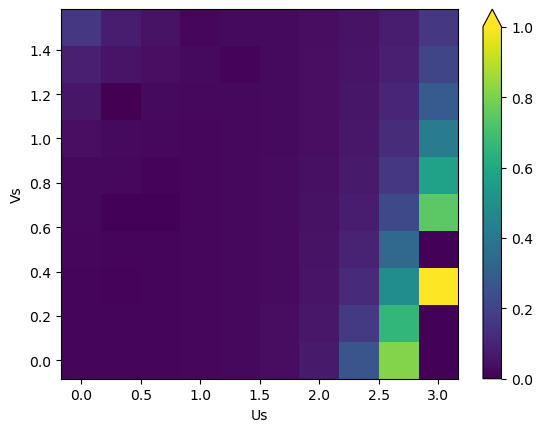

In [9]:
gap_da = xr.DataArray(data=gap, coords=dict(Us=Us, Vs=Vs))
gap_da.plot(x="Us", y="Vs", vmin=0, vmax=1)

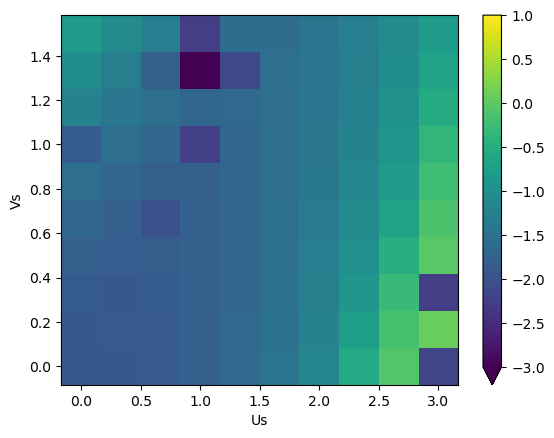

In [20]:
np.log10(gap_da).plot(x="Us", y="Vs", vmin=-3, vmax=1) 

0.02672641009348376

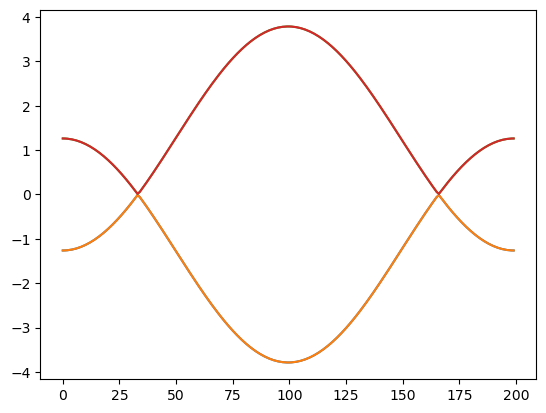

In [37]:
#Single shot calculation
params = dict(U=0, V=1)
filling = 2 

h_int = utils.builder_to_tb(int_builder, params)
model = Model(h_0, h_int, filling)
mf_guess = utils.generate_guess(frozenset(h_int), len(list(h_0.values())[0]))
mf_sol = solver(model, mf_guess, nK=30)

ks = np.linspace(-np.pi, np.pi, 200)
hkfunc = tb2kfunc(addTb(h_0, mf_sol))
hkarray = np.array([hkfunc((kx, -kx)) for kx in ks])
vals = np.linalg.eigvalsh(hkarray)
plt.plot(vals)
utils.calc_gap(vals, E_F=0)

In [2]:

import numpy as np
from codes.model import Model
from codes import kwant_examples
from codes.kwant_helper import utils
import timeit
import memray




In [3]:
graphene_builder, int_builder = kwant_examples.graphene_extended_hubbard()

params = {"U": 0.5, "V": 1.1}
filling = 2
nK = 300

h_int = utils.builder_to_tb(int_builder, params)
h_0 = utils.builder_to_tb(graphene_builder)
guess = utils.generate_guess(frozenset(h_int), len(list(h_0.values())[0]))

model = Model(h_0, h_int, filling)


def scf_loop():
    model.mfield(guess, nK=nK)


# %% Memory profile
with memray.Tracker("memoryProfile.bin"):
    scf_loop()




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
# %% Time profiler
profiler = Profiler()

profiler.start()
scf_loop()
profiler.stop()
profiler.write_html(path="timeProfile.html")



In [5]:
# %%
number = 1

timeSCF = timeit.timeit(scf_loop, number=number) / number

H = np.random.rand(nK, nK)
H += H.T.conj()
timeDiag = timeit.timeit(lambda: np.linalg.eigh(H), number=number) / number

print(
    f"Single SCF loop takes {timeSCF} whereas a single diagonalization of a corresponding system takes {timeDiag}"
)

Single SCF loop takes 7.120591291008168 whereas a single diagonalization of a corresponding system takes 0.024635875000967644
